# boundary_conditions

> Create slip-wall boundary conditions, create initial conditions for "primitive streak" (disk), and "germ band" (rectangle), and run simulations with patterned feedback parameter


In [ ]:
#| default_exp jax_experiments

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *
from CE_simulation.isogonal import *

In [ ]:
#| export
import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from copy import deepcopy

from collections import Counter, defaultdict

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

## creating initial conditions

In [ ]:
#| export

def get_triangular_lattice(nx, ny):
    """get triangular lattice with nx, ny points. Return a mask which delinates bdry vertices""" 

    y = np.arange(0, ny)*sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)
    X -= X.mean()+1/2; Y -=Y.mean()
    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    is_bdry = np.zeros_like(X)
    is_bdry[:1] = is_bdry[-1:] = 1
    is_bdry[:,:1] = is_bdry[:,-1:] = 1
    is_bdry = is_bdry.reshape(nx*ny)
    
    return pts, is_bdry

def create_rect_mesh(nx, ny, noise=0, defects=(0,0), straight_bdry=False):
    pts, is_bdry = get_triangular_lattice(nx, ny)
    pts[:,~is_bdry.astype(bool)] += np.random.normal(scale=noise, size=(2, (~is_bdry.astype(bool)).sum()))
    if defects[0] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[0], replace=False)
        pts = np.delete(pts, ix, axis=1)
    if defects[1] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[1], replace=False)
        split = np.random.choice((0,1), len(ix))
        additional_pts =  pts[:, ix] + .3*np.stack([1-split, split]) 
        pts[:, ix] -= .3*np.stack([1-split, split]) 
        pts = np.hstack([pts, additional_pts])
    
    tri = spatial.Delaunay(pts.T)
    # remove the left, right edge
    if straight_bdry:
        simplices = tri.simplices
    else:
        max_x, min_x = (pts[0].max(), pts[0].min())
        simplices = np.stack([x for x in tri.simplices
                          if (np.isclose(pts[0,x], min_x).sum()<2) and (np.isclose(pts[0,x], max_x).sum()<2)])
    pre_mesh = ListOfVerticesAndFaces(tri.points, simplices)
    mesh = HalfEdgeMesh(pre_mesh)
    
    return mesh

# might want to add the corner pts.

## Experimentation with jax

In [ ]:
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit, vmap
from jax import hessian
from jax import lax
from jax.ops import segment_sum

from jax.scipy.optimize import minimize as jminimize

In [ ]:
from jax import hessian, hessian

In [ ]:
#| export

@patch
def get_primal_energy_fct_jax(self: HalfEdgeMesh, bdry_list=None):
    """Get arrays necessary to compute primal energy from primal vertices. Cell based shape tensor.
    bdry_penalty_fcts: (2, ...) -> energy. bdry_ids = [vertex id,]
    """

    # book-keeping
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    n_faces = len(self.faces)
    
    # stuff for boundary energy
    bdry_list = [] if bdry_list is None else bdry_list
    bdry_list = [bdry + [[]] # 4th entry is for the cell ids 
                 #[jnp.stack([face_key_dict[fc._fid]
                 #    for fc in self.vertices[v].get_face_neighbors() if fc is not None])
                 # for v in bdry[2]]]
                 for bdry in bdry_list]
    
    # stuff for the shape tensor energy
    cell_list = []
    rest_shapes = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = jnp.array([face_key_dict[fc._fid] for fc in neighbors])
            cell_list.append(cell)
            # check if the cell is in any bdry:
            for bdry in bdry_list:
                if v._vid in bdry[2]:
                    bdry[3].append(len(cell_list)-1)
            
            rest_shapes.append(v.rest_shape)
    valences = [len(cell) for cell in cell_list]
    max_valence = max(valences)
    valence_mask = anp.array([x*[1,]+(max_valence-x)*[0,] for x in valences])
    # valence mask = (n_cells, max_valence). entry for each cell indicates whether a vertex is a duplicate
    cell_list = jnp.array([anp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    rest_shapes = jnp.stack(rest_shapes)
    bdry_list = [[bdry[0], bdry[1], jnp.array(bdry[3])] for bdry in bdry_list]

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = jnp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = jnp.array(e_dual)
    e_lst_primal = jnp.array(e_lst_primal)        
    
    return e_lst_primal, e_dual, cell_list, bdry_list, valence_mask
    
@jit 
def get_E(x0, e_lst_primal, e_dual, cell_list, bdry_list, valence_mask,
          mod_bulk=1, mod_shear=.1, angle_penalty=100, bdry_penalty=10, epsilon_l=1e-3):
    n_faces = int(x0.shape[0]/2)
    x, y = (x0[:n_faces], x0[n_faces:])
    pts = jnp.stack([x, y], axis=-1)
    
    # face-based shape energy
    cells = jnp.stack([pts[i] for i in cell_list.T], axis=0)
    edges = cells - jnp.roll(cells, 1, axis=0)
    lengths = jnp.linalg.norm(edges, axis=-1) + epsilon_l
    units = (edges.T/lengths.T).T
    tensors = jnp.einsum('efi,efj->fij', edges, units)  # units
    delta = tensors - jnp.sqrt(3)*jnp.array([[1.,0],[0,1.]], dtype=jnp.float32)
    E_shape = (mod_shear*4*jnp.mean(delta**2) + mod_bulk*jnp.mean((delta[:,0,0]+delta[:,1,1])**2))
    
    # angle penalty
    e_primal = pts[e_lst_primal[:,1],:] - pts[e_lst_primal[:,0],:] # he.twin.face-he.face
    lengths = jnp.linalg.norm(e_primal, axis=-1)+epsilon_l
    # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
    E_angle = angle_penalty*anp.mean(1-jnp.einsum('ei,ei->e', e_primal, e_dual)/lengths)
    
    # boundary conditions
    E_bdry = 0
    for bdry in bdry_list:
        centroid = (jnp.sum(cells[:,bdry[2]].T*valence_mask[bdry[2]], axis=-1)
                    /jnp.sum(valence_mask[bdry[2]],axis=-1))
        E_bdry = E_bdry+jnp.sum((centroid[bdry[0]]-bdry[1])**2)
    return E_shape + E_angle + E_bdry

get_E_jac = jit(jgrad(get_E))


## Examples

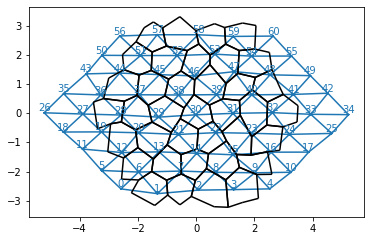

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=9, nx=9) # (7,7)

mesh.set_voronoi()
mesh.set_rest_lengths()

for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=0.1))
mesh.transform_vertices(lambda x: shear_mat(1.3)@x+np.random.normal(size=2, scale=0.05)) #0.075

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");

# format: 0,1 for x or y, target value, ids of cells
y_max = 3.4
bdry_up = [1, y_max, [51, 52, 53, 54]] #14
bdry_down = [1, -y_max, [6, 7, 8, 9]] #5
bdry_list = (bdry_up, bdry_down)

In [ ]:
np.mean([val for val in mesh.get_angle_deviation().values()])

0.26496259749636497

In [ ]:
mod_bulk = 1
mod_shear = .5
angle_penalty = 1000
bdry_penalty = 100

epsilon_l = 1e-5

cell_shape_args = (mod_bulk, mod_shear, angle_penalty, bdry_penalty, epsilon_l)

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E_arrays = mesh.get_primal_energy_fct_jax(bdry_list)

In [ ]:
_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args))

get_E(x0, *get_E_arrays)

DeviceArray(11.775479, dtype=float32)

In [ ]:
%%timeit
get_E(x0, *(get_E_arrays+cell_shape_args))

25.3 µs ± 9.74 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
get_E_jac(x0, *(get_E_arrays+cell_shape_args))

23.9 µs ± 739 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                        method="CG", tol=1e-3, options={"maxiter": 500})

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print(sol["fun"] , get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"])

# takes: 580ms with BFGS, 30 ms with CG. Hessian-based methods are not eally better

# small system: 6ms without bdry. with bdry: 13

Desired error not necessarily achieved due to precision loss. n_eval:  624 614
0.5586217045783997 125.75563
CPU times: user 108 ms, sys: 371 µs, total: 109 ms
Wall time: 109 ms


In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]


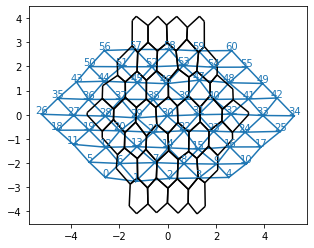

In [ ]:
mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");


## Pre jax rewrite

`get_E`: 321 micro s
`jac`: 2.57 ms
`optimize.minimize` with `BFGS`: 1.25 s
`optimize.minimize` with `CG`: 2.5 s

Error  = 900x lower than initial.

for 13x14 mesh

Post jax rewrite, using jit:

`get_E`: 13 micro s
`jac`: 30 micro s
`optimize.minimize` with `BFGS`: 560 ms, 
`optimize.minimize` with `BFGS`: 110 ms, 


Problem: massive speedup in energy function and gradient evaluation not translated into optimizer performance. The reason being that the optimizer only spends ca 1/3 of its time doing function/jacobian evaluations!

With the now much lower cost, using a routine which makes more function calls can be faster. In particular CG. Which is now much faster. This the yields an overall speedup of 10x.


Can sometimes terminate with precision loss error. But only at large noise I think? Desired error not necessarily achieved due to precision loss.

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Would be better to make this more gradual ofc.

Note: this is not actually working perfec

Energy based bdry condition method appears much more reasonable

### To - do: In a refactoring step, put the boundary energy back into notebook 3
 Keep tests here though!

Else, try a germ band with only half a lateral side

In [ ]:
@patch
def euler_step(self: HalfEdgeMesh, dt=.005, rhs=excitable_dt_post, params=None,
               rhs_rest_shape=None):
    """RHS: callable Ts, Tps -> dTs_dt, dTps_dt. Params can either be a dict of keyword args
    to the RHS function, or a callable faceid -> keyword dict.
    rhs_rest_shape: v -> d_rest_shape_dt, for rest shape dynamics (e.g. viscous relaxation)
    """
    rhs_rest_shape = (lambda fc: 0) if rhs_rest_shape is None else rhs_rest_shape
    for fc in self.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        if isinstance(params, dict):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params)
        elif callable(params):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params(fc._fid))
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    for v in self.vertices.values():
        v.rest_shape += dt*rhs_rest_shape(v)


In [ ]:
@patch
def optimize_cell_shape(self: HalfEdgeMesh, energy_fct_kwargs=None, tol=1e-3, maxiter=250, verbose=True):
    """primal optimization"""
    energy_fct_kwargs = dict() if energy_fct_kwargs is None else energy_fct_kwargs
    get_E, jac = self.get_primal_energy_fct_cells_bdry(**energy_fct_kwargs)
    x0 = self.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

In [ ]:
#| export

def excitable_dt_act_pass(Ts, Tps, k=1, m=2):
    """Time derivative of tensions under excitable tension model with constrained area,
    with passive tension for post intercalation. Variant: completely deactivate feedback for m=1"""
    dT_dt = (m-1)*((Ts-Tps)**m - k*Tps)
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt, dTp_dt


In [ ]:
# 1) no boundary condition -> CE flow as expected. however, the type of boundary
# (not a clean cut) in create_rect_mesh can lead to problems. so use trimesh for a sec
# 2) now try patterned feedback. also looks reasonable. now try plotting the shape energies. done
# 3) now add boundary condition. also works. energy increases!

In [ ]:
#| notest
%matplotlib inline

<IPython.core.display.Javascript object>


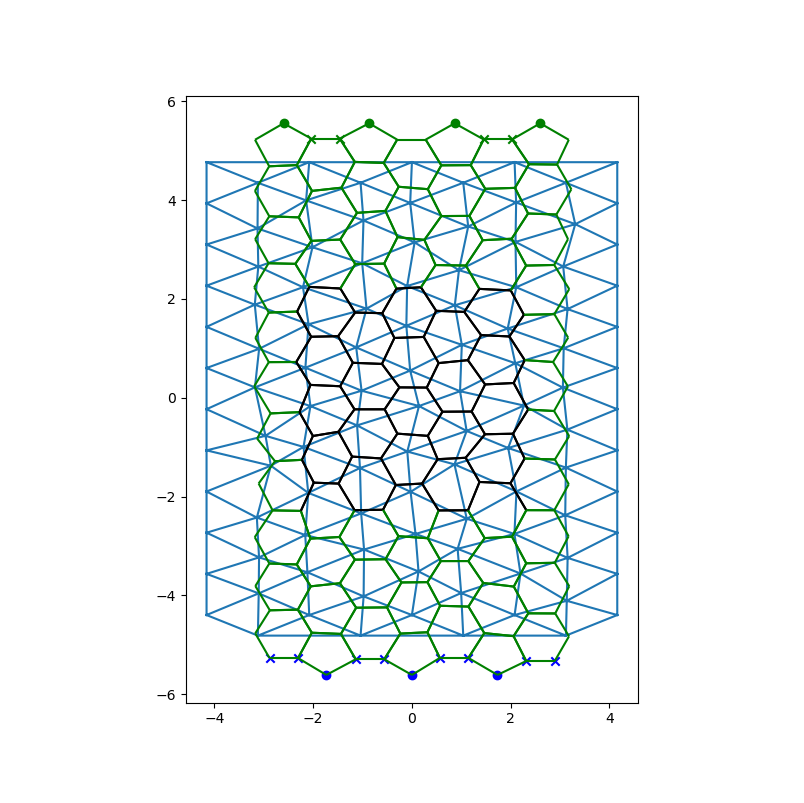

In [ ]:
# create a mesh, and set passive regions. Need to wrap this as function!

mesh = create_rect_mesh(12, 9, noise=0.075, defects=(0,0), straight_bdry=True) #0.075 False

#for val in mesh.hes.values():
#    val.rest = 1
#mesh.flatten_triangulation()

mesh.transform_vertices(rot_mat(pi/2))
center = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-center)
#mesh = get_tri_hemesh(noise=0.04, ny=9, nx=7)  # try larger noise. workgks for 0 noise

mesh.set_centroid()
for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

s = 1.2 #1.15
mesh.transform_vertices(shear_mat(s))
#mesh.transform_dual_vertices(shear_mat(s))

mesh.set_rest_lengths()

# set the boundary conditions and mark the active and passive vertices
passive_ids = []
active_ids = []
bdry_ids = [[], [], [], []]

max_y = np.max([val.dual_coords[1] for val in mesh.faces.values()])
w_passive = 3
for fc in mesh.faces.values():
    if fc.is_bdr():
        passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)
    if fc.is_bdr() and fc.dual_coords[1] > max_y-.1:
        bdry_ids[0].append(fc._fid)
    if fc.is_bdr() and fc.dual_coords[1] < -(max_y-.1):
        bdry_ids[1].append(fc._fid)
    if fc.is_bdr() and max_y-.1 > fc.dual_coords[1] > max_y-.33:
        bdry_ids[2].append(fc._fid)
    if fc.is_bdr() and -(max_y-.1) < fc.dual_coords[1] < -(max_y-.33):
        bdry_ids[3].append(fc._fid)


passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)
bdry_coords = [("y", max_y), ("y", -max_y), ("y", max_y-.33), ("y", -max_y+.33)]
bdry_penalty_fcts = [lambda x: (x[1]-max_y)**2, lambda x: (x[1]+max_y)**2]

passive_edges = flatten([[he._heid for he in mesh.faces[fc].hes] for fc in passive_ids])
edge_colors = {key: "g" for key in passive_edges}

fig = plt.figure(figsize=(8,8))

mesh.triplot()
mesh.cellplot(edge_colors=edge_colors)

#for key in passive_ids:
#    plt.scatter(*mesh.faces[key].dual_coords, c="r")
for key in bdry_ids[0]:
    plt.scatter(*mesh.faces[key].dual_coords, c="g")
for key in bdry_ids[2]:
    plt.scatter(*mesh.faces[key].dual_coords, c="g", marker="x")
for key in bdry_ids[1]:
    plt.scatter(*mesh.faces[key].dual_coords, c="b")
for key in bdry_ids[3]:
    plt.scatter(*mesh.faces[key].dual_coords, c="b", marker="x")


plt.gca().set_aspect("equal", adjustable="box");

## To do

boundary condition: better pin the centroids of cells than vertices! this leaves freedom to fullfill the angle constraints!

In [ ]:
# with the rectangular geometry, I get a weird phenomenon: the patch compresses in the x-direction
# losing area, instead of extending. not sure why!!

In [ ]:
## set simulation parameters

# function for active and passive
k = 2
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1}
    return {"k": k, "m": 2}

params_no_pattern = {"k": k, "m": 2}

k_rest = 5
def rhs_rest_shape(v):
    """Rest shape relaxation nut do not relax area, i.e. trace"""
    delta = v.rest_shape-v.get_shape_tensor()
    return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))

dt = .01
n_steps = 60

minimal_l = .075

mod_bulk = 1
mod_shear = 0.001
angle_penalty = 500

reg_bulk =  0
A0 = sqrt(3)/2  # causes super bizzare optimization problems. need to investigate

epsilon_l = 1e-6

bdry_penalty = 100

forbid_reflip = 40
tol, maxiter = (.5*1e-4, 2000)
cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "reg_bulk": reg_bulk, "A0": A0,
                   "bdry_ids": bdry_ids,
                   #"bdry_coords": bdry_coords, # energy
                   "bdry_penalty_fcts": bdry_penalty_fcts, "bdry_penalty": bdry_penalty,
                   "epsilon_l": epsilon_l}

In [ ]:
## simulation loop

meshes = []
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

#mesh.set_voronoi()
#mesh.set_bdry(bdry_ids, bdry_coords)

for i in tqdm(range(n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation()
    # primal optimization
    mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=True)
    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens(oriented=True)
    flipped = []
    for key, val in primal_lengths.items():
        conditions = (val < minimal_l)
        conditions &= not any([key in x for x in last_flipped_edges[-forbid_reflip:]])
        conditions &= i>0
        if conditions:  
            try:
                print(f"flip {key}, tpt {i}")
                he = mesh.hes[key]
                mesh.flip_edge(key)
                mesh.reset_rest_passive_flip(he, method="smooth") # smooth
                f0, f1 = (he.face, he.twin.face)
                f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords,
                                                                               f1.dual_coords]))
                flipped.append(he._heid)
            except ValueError:
                continue
    if flipped:
        mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=True)

    center = anp.median([v.coords for v in mesh.vertices.values()], axis=0)
    mesh.transform_vertices(lambda x: x-center)

    center = anp.median([fc.dual_coords for fc in mesh.faces.values()], axis=0)
    mesh.transform_dual_vertices(lambda x: x-center*np.array([1,0])) 
    # meed to rename that method confusing as it refers to primal vertices I think??

    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

  0%|          | 0/60 [00:00<?, ?it/s]

flip 28, tpt 4
flip 91, tpt 10
flip 93, tpt 16
flip 57, tpt 20
flip 228, tpt 20
flip 210, tpt 21
flip 99, tpt 21
flip 60, tpt 22
flip 183, tpt 22
flip 204, tpt 22
flip 51, tpt 23
flip 240, tpt 23
flip 324, tpt 23
flip 339, tpt 23
flip 378, tpt 23
flip 34, tpt 24
flip 105, tpt 24
flip 177, tpt 24
flip 64, tpt 25
flip 244, tpt 25
flip 42, tpt 26
flip 48, tpt 26
flip 97, tpt 31
flip 426, tpt 32
flip 87, tpt 36
flip 394, tpt 37
flip 546, tpt 37
flip 345, tpt 38
flip 112, tpt 40
flip 514, tpt 40
flip 510, tpt 40
flip 400, tpt 41
flip 309, tpt 41
flip 121, tpt 41
flip 303, tpt 41
flip 390, tpt 41
flip 294, tpt 41
flip 316, tpt 41
flip 357, tpt 41
flip 516, tpt 41
flip 438, tpt 42
flip 292, tpt 42
flip 409, tpt 42
flip 502, tpt 42
flip 508, tpt 42
flip 312, tpt 43
flip 435, tpt 43
flip 370, tpt 44
flip 151, tpt 48
flip 307, tpt 49
flip 109, tpt 49
flip 406, tpt 49
flip 429, tpt 49
flip 459, tpt 49
flip 21, tpt 50
flip 432, tpt 50
flip 504, tpt 50
flip 82, tpt 51
flip 91, tpt 51
flip 277, tpt 